In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

#### Funkce pro vykreslení podobnostní metriky při každé iteraci

In [2]:
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, 
             [metric_values[index] for index in multires_iterations],
             "b*",)
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
   
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values)) 
    
def metric_and_reference_start_plot():
    global metric_values, multires_iterations
    global min_values, max_values, mean_values
    global current_iteration
    
    metric_values = []
    multires_iterations = []
    mean_values = []
    min_values = []
    max_values = []
    current_iteration = -1
    
def metric_and_reference_stop_plot():
    global metric_values, multires_iterations
    global min_values, max_values, mean_values
    global current_iteration
    
    plt.close()
    
def metric_and_reference_plot_values(registration_method, fixed_points, moving_points):
    global metric_values, multires_iterations
    global min_values, max_values, mean_values
    global current_iteration
    
    if registration_method.GetOptimizerIteration() == current_iteration:
        return
    
    current_iteration = registration_method.GetOptimizerIteration()
    metric_values.append(registration_method.GetMetricValue())
    
    current_transform = sitk.CompositeTransform(registration_method.GetInitialTransform())
    current_transform.SetParameters(registration_method.GetOptimizerPosition())
    current_transform.AddTransform(registration_method.GetMovingInitialTransform())
    current_transform.AddTransform(registration_method.GetFixedInitialTransform().GetInverse())
    
    mean_error, _, min_error, max_error, _ = getRegistrationErrors(current_transform, fixed_points, moving_points)
    
    mean_values.append(mean_error)
    min_values.append(min_error)
    max_values.append(max_error)
    """
    clear_output(wait=True)
    # Plot the similarity metric values.
    plt.subplot(1, 2, 1)
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    # Plot the TRE mean value and the [min-max] range.
    plt.subplot(1, 2, 2)
    plt.plot(mean_values, color="black", label="mean")
    plt.fill_between(range(len(mean_values)), min_values, max_values,
                     facecolor="red", alpha=0.5)
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Míra nepřesnosti registrace (TRE) [mm]", fontsize=12)
    plt.legend()

    # Adjust the spacing between subplots so that the axis labels don't overlap.
    plt.tight_layout()
    plt.show()
    """
    
def getPoints(path):
    pointList = []
    with open(path, "r") as pointsFile:
        [pointList.append(line.split(",")[1:4]) for line in pointsFile.readlines()[1:]]
        pointList = [[float(coords) for coords in sublist] for sublist in pointList]
        return pointList
    
def getRegistrationErrors(transform, fixed_points, moving_points):
    inverseTransform = transform.GetInverse()
    transformed_points = [inverseTransform.TransformPoint(p) for p in moving_points]
    errors = [np.linalg.norm(np.array(p_fixed) - np.array(p_moving)) 
              for p_fixed, p_moving in zip(fixed_points, transformed_points)]
    
    return np.mean(errors), np.std(errors), np.min(errors), np.max(errors), errors

def plotRegistrationErrors():
    figMetric, axMetric = plt.subplots(1, 1)
    axMetric.plot(metric_values, "#1f77b4")
    axMetric.plot(multires_iterations, [metric_values[index] for index in multires_iterations], marker="o", 
                  label="Registrační úroveň", linestyle="none", 
                  markeredgecolor="none", markersize=6., c="#ff7f0e")
    axMetric.set_xlabel("Počet iterací [-]", fontsize=11)
    axMetric.set_ylabel("Vzájemná informace [-]", fontsize=11)
    axMetric.legend()
    axMetric.set_title("Optimalizace podobnostní metriky")
    
    # Plot the TRE mean value and the [min-max] range.
    figTre, axTre = plt.subplots(1, 1)
    axTre.plot(mean_values, color="black", label="Průměr")
    axTre.fill_between(range(len(mean_values)), min_values, max_values,
                     facecolor="red", alpha=0.5)
    axTre.set_xlabel("Počet iterací", fontsize=11)
    axTre.set_ylabel("Rozdíl vzdáleností (TRE) [mm]", fontsize=11)
    axTre.set_title("Míra nepřesnosti registrace")
    axTre.legend()

    # Adjust the spacing between subplots so that the axis labels don't overlap.
    plt.show()

#### Načtení a vykreslení obrazů

In [3]:
fixedImage = sitk.ReadImage("input_files\\pacient_09\\registration\\pacient09PreopAP.mha", sitk.sitkFloat32)
movingImage = sitk.ReadImage("input_files\\pacient_09\\registration\\pacient09IntraopAP.mha", sitk.sitkFloat32)

fixedPoints = getPoints("input_files\\pacient_09\\registration\\pacient09FixedPointsAP.csv")
movingPoints = getPoints("input_files\\pacient_09\\registration\\pacient09MovingPointsAP.csv")

Fixed image, spacing: (1.0, 1.0, 0.25), size: (1000, 1000, 4),direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), origin: (0.0, 0.0, -0.375)
Moving image, spacing: (1.0, 1.0, 0.25), size: (1000, 1000, 4),direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), origin: (0.0, 0.0, -0.375)


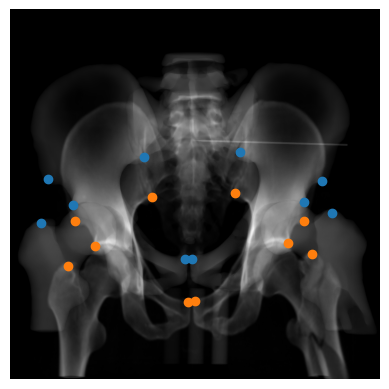

In [4]:
# fixedImage = preopImage
# movingImage = intraopImage

# fixedImage = sitk.Expand(intraopImage, expandFactors=[1, 1, 4])
# movingImage = sitk.Expand(preopImage, expandFactors=[1, 1, 4])

# movingImage.SetOrigin(fixedImage.GetOrigin())
# movingImage.SetSpacing(fixedImage.GetSpacing())
print(f"Fixed image, spacing: {fixedImage.GetSpacing()}, size: {fixedImage.GetSize()},"
      f"direction: {fixedImage.GetDirection()}, origin: {fixedImage.GetOrigin()}")
print(f"Moving image, spacing: {movingImage.GetSpacing()}, size: {movingImage.GetSize()},"
      f"direction: {movingImage.GetDirection()}, origin: {movingImage.GetOrigin()}")
plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(movingImage)[0, ...], cmap="gray", alpha=0.5)
plt.scatter(list(np.array(fixedPoints).T)[0], list(np.array(fixedPoints).T)[1], c="#1f77b4")
plt.scatter(list(np.array(movingPoints).T)[0], list(np.array(movingPoints).T)[1], c="#ff7f0e")
plt.axis("off")
plt.show()

In [5]:
initialTransform = sitk.CenteredTransformInitializer(fixedImage, movingImage,
                                                     sitk.AffineTransform(3),
                                                     sitk.CenteredTransformInitializerFilter.MOMENTS)

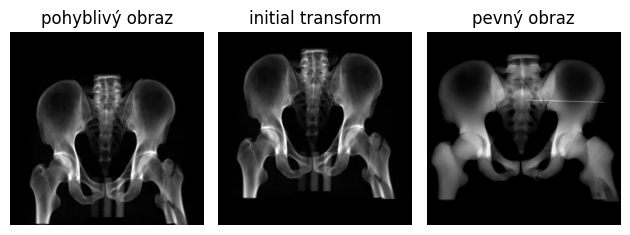

In [6]:
initialImage = sitk.Resample(movingImage, fixedImage, initialTransform, sitk.sitkLinear, 0.0, movingImage.GetPixelID())

fig3, ax2 = plt.subplots(1, 3)
ax2[0].imshow(sitk.GetArrayViewFromImage(movingImage)[0, ...], cmap="gray")
ax2[1].imshow(sitk.GetArrayViewFromImage(initialImage)[0, ...], cmap="gray")
ax2[2].imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
ax2[0].set_title("pohyblivý obraz")
ax2[1].set_title("initial transform")
ax2[2].set_title("pevný obraz")
ax2[0].axis("off")
ax2[1].axis("off")
ax2[2].axis("off")
fig3.tight_layout()
plt.show()

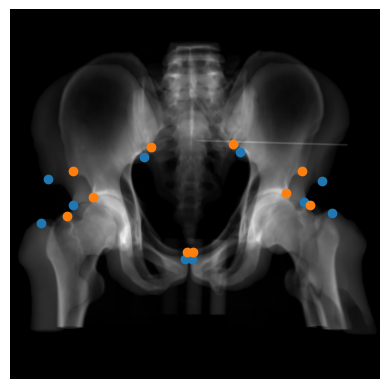

In [7]:
initialTransformInverse = initialTransform.GetInverse()
movingInitialPoints = [initialTransformInverse.TransformPoint(p) for p in movingPoints]

plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(initialImage)[0, ...], cmap="gray", alpha=0.5)
plt.scatter(list(np.array(fixedPoints).T)[0], list(np.array(fixedPoints).T)[1], c="#1f77b4")
# plt.scatter(list(np.array(movingPoints).T)[0], list(np.array(movingPoints).T)[1], c="r")
plt.scatter(list(np.array(movingInitialPoints).T)[0], list(np.array(movingInitialPoints).T)[1], c="#ff7f0e")
plt.axis("off")
plt.show()

In [8]:
levels = 3
shrinkFactor = [2 ** factor for factor in range(0, levels)][::-1]
smoothFactor = [factor for factor in range(0, levels)][::-1]

#### Inicializace registrace a její parametry

In [9]:
registration = sitk.ImageRegistrationMethod()
registration.SetMetricAsMattesMutualInformation(50)
registration.SetOptimizerScalesFromPhysicalShift()
registration.SetOptimizerAsGradientDescent(learningRate=1.0,
                                           numberOfIterations=200,
                                           convergenceMinimumValue=1e-5,
                                           convergenceWindowSize=5)
registration.SetInitialTransform(initialTransform, inPlace=False)
registration.SetInterpolator(sitk.sitkLinear)

registration.SetShrinkFactorsPerLevel(shrinkFactors=shrinkFactor)
registration.SetSmoothingSigmasPerLevel(smoothingSigmas=smoothFactor)
registration.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration.AddCommand(sitk.sitkStartEvent, metric_and_reference_start_plot)
registration.AddCommand(sitk.sitkEndEvent, metric_and_reference_stop_plot)
registration.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
registration.AddCommand(sitk.sitkIterationEvent, lambda: metric_and_reference_plot_values(registration,
                                                                                          fixedPoints,
                                                                                          movingPoints))
start_time = time.time()
outTransform = registration.Execute(fixedImage, movingImage)
print(f"Doba trvání: {time.time() - start_time}")
# print(f"Optimizer stop condition: {registration.GetOptimizerStopConditionDescription()}")
# print(f" Iteration: {registration.GetOptimizerIteration()}")
# print(f" Metric value: {registration.GetMetricValue()}")

Doba trvání: 8.724416732788086


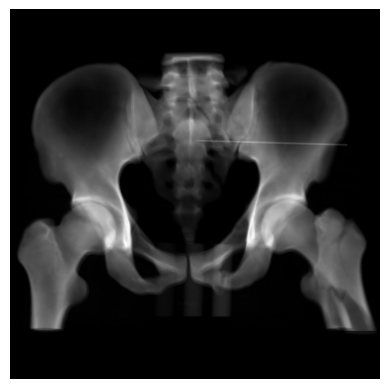

In [10]:
movingImageResampled = sitk.Resample(movingImage, fixedImage, outTransform, sitk.sitkLinear, 0.0, movingImage.GetPixelID())

plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(movingImageResampled)[0, ...], cmap="gray", alpha=0.5)
plt.axis("off")
plt.show()

In [11]:
outTransformInverse = outTransform.GetInverse()
movingFinalPoints = [outTransformInverse.TransformPoint(p) for p in movingPoints]

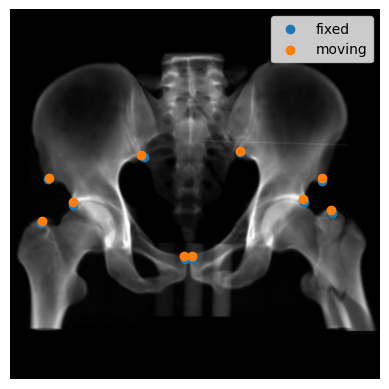

In [12]:
plt.imshow(sitk.GetArrayViewFromImage(movingImageResampled)[0, ...], cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray", alpha=0.2)
plt.scatter(list(np.array(fixedPoints).T)[0], list(np.array(fixedPoints).T)[1], c="#1f77b4")
# plt.scatter(list(np.array(movingPoints).T)[0], list(np.array(movingPoints).T)[1], c="r")
plt.scatter(list(np.array(movingFinalPoints).T)[0], list(np.array(movingFinalPoints).T)[1], c="#ff7f0e")
plt.legend(["fixed", "moving"])
plt.axis("off")
plt.show()

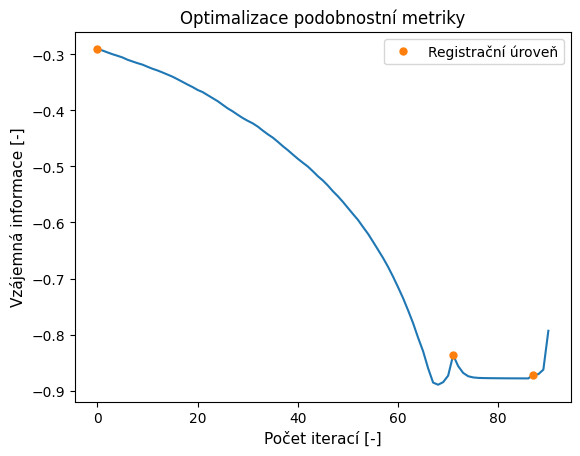

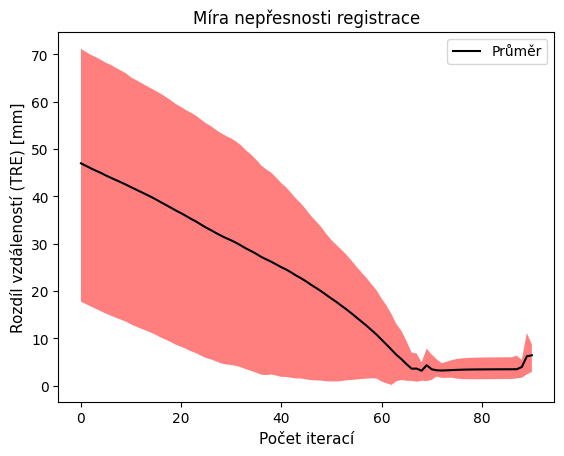

In [13]:
plotRegistrationErrors()

In [17]:
(pre_mean_error, pre_std_error, pre_min_error, 
 pre_max_error, pre_error) = getRegistrationErrors(sitk.Transform(), fixedPoints, movingPoints)
                              
(initial_mean_error, initial_std_error, initial_min_error, 
 initial_max_error, initial_error) = getRegistrationErrors(initialTransform, fixedPoints, movingPoints)

(final_mean_error, final_std_error, final_min_error, 
 final_max_error, final_error) = getRegistrationErrors(outTransform, fixedPoints, movingPoints)

In [ ]:
plt.hist(pre_error, bins=20, alpha=0.5, label="initial", color="blue")
plt.hist(final_error, bins=20, alpha=0.5, label="after", color="green")
plt.legend()

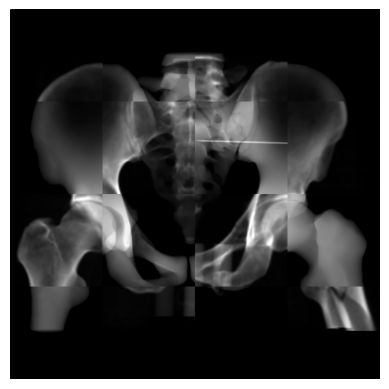

In [14]:
movingImageVis = movingImageResampled[..., 0]
fixedImageVis = fixedImage[..., 0]

movingImageResampled255 = sitk.Cast(sitk.IntensityWindowing(movingImageVis, 
                                                            windowMinimum=0., windowMaximum=32767., 
                                                            outputMinimum=0., outputMaximum=255.), 
                                                            sitk.sitkUInt8)
fixedImage255 = sitk.Cast(sitk.IntensityWindowing(sitk.RescaleIntensity(fixedImageVis, 0, 32767), 
                                                windowMinimum=0., windowMaximum=32767., 
                                                outputMinimum=0., outputMaximum=255.), 
                                                sitk.sitkUInt8)
plt.imshow(sitk.GetArrayViewFromImage(sitk.CheckerBoard(movingImageResampled255, fixedImage255, [4, 4])), 
           cmap="gray")
plt.axis("off")
plt.show()

#### Test detekce hran pro vizualizaci registrace

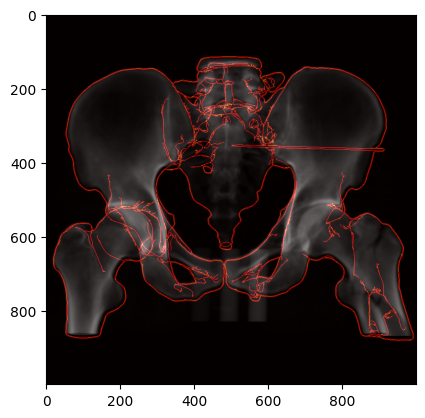

In [16]:
sitkImageEdges = sitk.CannyEdgeDetection(fixedImage[..., 0], lowerThreshold=0., upperThreshold=0.8)
plt.imshow(sitk.GetArrayViewFromImage(movingImageResampled255), cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(sitkImageEdges), cmap="hot", alpha=0.5)